In [ ]:
import os
import gc
import ast
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#######################
### Functions
#######################
# ----------------- Matplotlib / Seaborn Style -------------------
def configure_plot_style():
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    mpl.rcParams.update({
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'lines.linewidth': 1.5
    })


# ----------------- Data Loading Functions -------------------
def load_pmids():
    df = pd.read_csv("../data/fig2-3/PubTator3/Pubtator3_BioREX_pmid_mesh.csv")
    df["from_mesh"] = df["from_mesh"].apply(ast.literal_eval)
    return df


def load_similarity_scores(num_chunks=3):
    all_chunks = []
    for chunk in range(1, num_chunks + 1):
        df = pd.read_parquet(f"../data/fig2-3/All_MeSH_diseases_pmid_bert_corrs_chunk{chunk}.parquet")
        if chunk == 1:
            all_chunks.append(df[["pmid"]])
        all_chunks.append(df.drop(columns=["pmid"], errors='ignore'))
        del df
        gc.collect()
    return pd.concat(all_chunks, axis=1)


def load_mesh_categories():
    df = pd.read_csv("../data/fig2-3/MeSH/mesh_disease_leaves_w_annotation.csv")
    df["tree_categories"] = df["tree_categories"].apply(ast.literal_eval)
    return df


def load_category_mapping():
    df = pd.read_csv("../data/fig2-3/MeSH/MeSH_large_categories.csv")
    return dict(zip(df["mesh_id"], df["name"]))


# ----------------- Processing Functions -------------------
def create_mesh_one_hot(pmids_df, mesh_ids, mesh2use):
    mesh2idx = {mesh: idx for idx, mesh in enumerate(mesh2use)}
    mesh_oh = np.zeros((len(pmids_df), len(mesh2use)), dtype=int)

    for idx, row in tqdm(pmids_df.iterrows(), total=len(pmids_df)):
        for mesh in row["from_mesh"]:
            if mesh.startswith("MESH:"):
                mesh = mesh.split(":")[1]
                if mesh in mesh2idx:
                    mesh_oh[idx, mesh2idx[mesh]] = 1
    return mesh_oh


def compute_correlations(pmid_corrs, mesh_oh, mesh2use):
    corrs_pos, corrs_neg, mesh_ids = [], [], []

    for i, mesh_id in enumerate(tqdm(mesh2use)):
        if mesh_oh[:, i].sum() > 0:
            pos_idx = np.where(mesh_oh[:, i] == 1)[0]
            neg_idx = np.random.choice(np.where(mesh_oh[:, i] == 0)[0], len(pos_idx), replace=False)
            corrs_pos.extend(pmid_corrs.loc[pos_idx, mesh_id].values)
            corrs_neg.extend(pmid_corrs.loc[neg_idx, mesh_id].values)
            mesh_ids.extend([mesh_id] * len(pos_idx))
    return np.array(corrs_pos), np.array(corrs_neg), np.array(mesh_ids)


# ----------------- Plotting Functions -------------------
def plot_histogram(corrs_pos, corrs_neg, output_path):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.histplot(corrs_neg, bins=500, kde=True, color="blue", alpha=0.5, label="Negative", ax=ax)
    sns.histplot(corrs_pos, bins=500, kde=True, color="red", alpha=0.5, label="Positive", ax=ax)
    ax.set_xlabel("Normalized similarity score")
    ax.set_title("MeSH-Tagged vs. Non-MeSH-Tagged\nfor the Same Disease Query")
    ax.grid(True)
    plt.legend(fontsize=12, frameon=False)
    fig.tight_layout()
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


def plot_by_category(corrs_pos, corrs_neg, mesh_ids, cat2mesh, mesh_large2name, all_categories, output_path):
    fig, axes = plt.subplots(ncols=6, nrows=4, figsize=(24, 16))
    axes = axes.flatten()

    for i, category in enumerate(all_categories):
        category_name = mesh_large2name.get(category, category)
        mesh_ids2use = cat2mesh[category]
        mask = np.isin(mesh_ids, mesh_ids2use)

        sns.histplot(corrs_neg[mask], bins=100, kde=True, color="blue", alpha=0.5, ax=axes[i])
        sns.histplot(corrs_pos[mask], bins=100, kde=True, color="red", alpha=0.5, ax=axes[i])
        title = f"{category_name} ({category})"
        axes[i].set_title(title[:41] + "\n-" + title[41:] if len(title) > 41 else title)
        axes[i].grid(True)

    for j in range(len(all_categories), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


def plot_scatter(mesh_ids, corrs_pos, corrs_neg, mesh_category_df, output_path):
    df = pd.DataFrame({"mesh_id": mesh_ids, "corrs_positive": corrs_pos, "corrs_negative_no_tag": corrs_neg})
    df = df.groupby("mesh_id").mean().reset_index()
    df = df.merge(mesh_category_df[["mesh_id", "n_articles"]], on="mesh_id", how="left")

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.scatterplot(data=df, x="n_articles", y="corrs_negative_no_tag", color="blue", s=15, label="Negative", ax=ax)
    sns.scatterplot(data=df, x="n_articles", y="corrs_positive", color="red", s=15, label="Positive", ax=ax)
    ax.set_xscale("log")
    ax.set_xlabel("Number of articles")
    ax.set_ylabel("Normalized similarity score")
    ax.set_title("MeSH-Tagged vs. Non-MeSH-Tagged\nfor the Same Disease Query")
    ax.grid(True)
    plt.legend(fontsize=12, frameon=False)
    fig.tight_layout()
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


def plot_roc_curve(corrs_pos, corrs_neg, output_path):
    scores = np.concatenate([corrs_pos, corrs_neg])
    labels = np.concatenate([np.ones(len(corrs_pos)), np.zeros(len(corrs_neg))])
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auroc = auc(fpr, tpr)

    j_scores = tpr - fpr
    optimal_idx = j_scores.argmax()
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    print(f"AUROC: {auroc:.4f}")
    print(f"Optimal threshold: {optimal_threshold:.4f}")

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, color="black", lw=2.0, label=f"AUROC = {auroc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1)
    ax.plot(optimal_fpr, optimal_tpr, marker='o', color='red', markersize=8, label="Optimal point")
    ax.annotate(
        f"Threshold = {optimal_threshold:.3f}\nTPR = {optimal_tpr:.3f}\nFPR = {optimal_fpr:.3f}",
        xy=(optimal_fpr, optimal_tpr),
        xytext=(optimal_fpr + 0.1, optimal_tpr - 0.2),
        arrowprops=dict(arrowstyle="->", color='black'),
        fontsize=13,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )
    ax.set_xlabel("False Positive Rate (FPR)", fontsize=14)
    ax.set_ylabel("True Positive Rate (TPR)", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12, frameon=False)
    fig.tight_layout()
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    return scores, labels, optimal_threshold


def evaluate_threshold(scores, labels, threshold=0.2):
    y_pred = (scores >= threshold).astype(int)
    precision = precision_score(labels, y_pred)
    recall = recall_score(labels, y_pred)
    f1 = f1_score(labels, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

In [ ]:
# Main Execution
configure_plot_style()

pmids_df = load_pmids()
sim_df = load_similarity_scores()
mesh_category_df = load_mesh_categories()
mesh_large2name = load_category_mapping()

mesh2use = sim_df.columns[1:]
pmids_df = pmids_df.set_index("pmid").loc[sim_df["pmid"].values].reset_index()

mesh_oh = create_mesh_one_hot(pmids_df, sim_df["pmid"].values, mesh2use)
corrs_pos, corrs_neg, mesh_ids = compute_correlations(sim_df, mesh_oh, mesh2use)

# Tree category mapping
if isinstance(mesh_category_df["tree_categories"].iloc[0], str):
    mesh_category_df["tree_categories"] = mesh_category_df["tree_categories"].apply(ast.literal_eval)
all_categories = sorted(set(itertools.chain(*mesh_category_df["tree_categories"].values)) - {"C22"}) # Exclude "C22" as it is not related to diseases
cat2mesh = {
    cat: mesh_category_df[mesh_category_df["tree_categories"].apply(lambda x: cat in x)]["mesh_id"].values
    for cat in all_categories
}

In [ ]:
# Visualization & Evaluation
plot_histogram(corrs_pos, corrs_neg, "../data/fig2-3/fig2.all_mesh_tagged_vs_non_tagged.png")
plot_by_category(corrs_pos, corrs_neg, mesh_ids, cat2mesh, mesh_large2name, all_categories,
                    "../data/fig2-3/fig2.supple.all_mesh_tagged_vs_non_tagged_by_category.png")
plot_scatter(mesh_ids, corrs_pos, corrs_neg, mesh_category_df, "../data/fig2-3/fig2.supple.all_mesh_tagged_vs_non_tagged_scatter.png")
scores, labels, optimal_th = plot_roc_curve(corrs_pos, corrs_neg, "../data/fig2-3/fig2.all_mesh_roc_curve.png")
evaluate_threshold(scores, labels, threshold=0.2)

In [ ]:
# The number of detected articles
th = 0.2
pmid_corrs_np = pmid_corrs.iloc[:, 1:].values
bert_based_count = (pmid_corrs_np > th).sum(axis=0)

In [14]:
import requests
from xml.etree import ElementTree as ET
import random
import time

def get_pubmed_counts(mesh_id):
    sleep_time = random.uniform(0.5, 1.0)
    time.sleep(sleep_time)

    # Fist, get the total number of hits
    query = mesh_id2name[mesh_id]
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&rettype=count"
    response = requests.get(url)
    if not response.status_code == 200:
        print(f"[{mesh_id}] Error: {response.status_code}")
        return None
    else:
        root = ET.fromstring(response.text)
        total_hits = int(root.find("Count").text)

        # Second, get the pmids
        retmax = 100000
        total_pmids = set()
        for retstart in range(0, total_hits, retmax):
            url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retstart={retstart}&retmax={retmax}"
            response = requests.get(url)
            if not response.status_code == 200:
                print(f"[{mesh_id}] Error: {response.status_code}")
                return None
            else:
                root = ET.fromstring(response.text)
                pmids = [id_elem.text for id_elem in root.findall(".//Id")]
                total_pmids.update(set(pmids))
        
        # Third, get the intersection with the pmids2use
        count = len(set(pmid2use.astype(str)) & total_pmids)
        return count

pubmed_api_counts = []
for mesh_id in tqdm(mesh2use):
    count = get_pubmed_counts(mesh_id)
    pubmed_api_counts.append(count)

pubmed_api_counts = [int(x) for x in pubmed_api_counts if x is not None]
pubmed_api_counts = np.array(pubmed_api_counts)
np.save("../data/output/ex17/pubmed_api_counts.npy", pubmed_api_counts)

  0%|          | 0/2141 [00:00<?, ?it/s]

100%|██████████| 2141/2141 [1:58:04<00:00,  3.31s/it]  


/tmp/ipykernel_2421547/1302816810.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plt_df, x="type", y="count", palette=["gray", "pink", "red"], ax=ax, width=0.5)


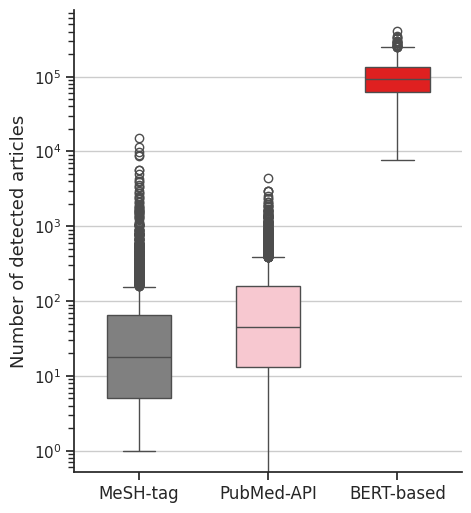

: 

In [ ]:
import matplotlib as mpl
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['axes.labelsize'] = 13

plt_df = pd.DataFrame({"count": np.concatenate([mesh_tag_counts, pubmed_api_counts, bert_based_count]),
                       "type": ["MeSH-tag"]*len(mesh_tag_counts) + ["PubMed-API"]*len(pubmed_api_counts) + ["BERT-based"]*len(bert_based_count)})
fig, ax = plt.subplots(figsize=(5,6))
# pelette = [sns.color_palette()[-3], sns.color_palette("RdBu")[-1], sns.color_palette("RdBu")[0]]
sns.boxplot(data=plt_df, x="type", y="count", palette=["gray", "pink", "red"], ax=ax, width=0.5)
ax.set_yscale("log")
ax.set_xlabel("")
ax.set_ylabel("Number of detected articles")
ax.grid(True, axis="y")
plt.show()

fig.savefig("../data/output/ex17/ex17_number_of_detected_articles.png", dpi=300, bbox_inches="tight")

In [54]:
(bert_based_count / mesh_tag_counts).mean()

14579.185146722648